In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import plot_model
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import datetime
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.4.1
Num GPUs Available:  1


In [3]:
#load dir for folder
trainFolder = "/content/gdrive/My Drive/image/train/"
testFolder = "/content/gdrive/My Drive/image/test/"
totalLabelsTrain = len(os.listdir(trainFolder))
totalLabelsTest = len(os.listdir(testFolder))

In [4]:
#calculate dataset
def count_datase(path):
            
    df = {}
    for i in os.listdir(path):
        directory = path + i
        df[i] = len(os.listdir(directory))
    df = pd.DataFrame(df, index=["Total"]).transpose().sort_values("Total", ascending=False)
    return df
    
train_count = count_datase(trainFolder)
test_count = count_datase(testFolder)
print("Train data set  data")
print(train_count)
print("")
print("Testing data set count")
print(test_count)

Train data set  data
          Total
happy      7215
neutral    4965
sad        4830
fear       4097
angry      3995
surprise   3171
disgust     436

Testing data set count
          Total
happy      1774
sad        1247
neutral    1233
fear       1024
angry       958
surprise    831
disgust     111


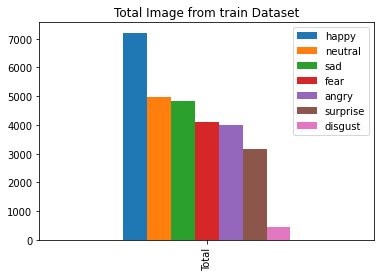

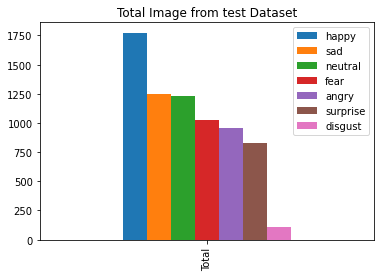

In [5]:
#Ploting all total dataset
train_count.transpose().plot(kind = 'bar', title="Total Image from train Dataset")
test_count.transpose().plot(kind = 'bar', title="Total Image from test Dataset")

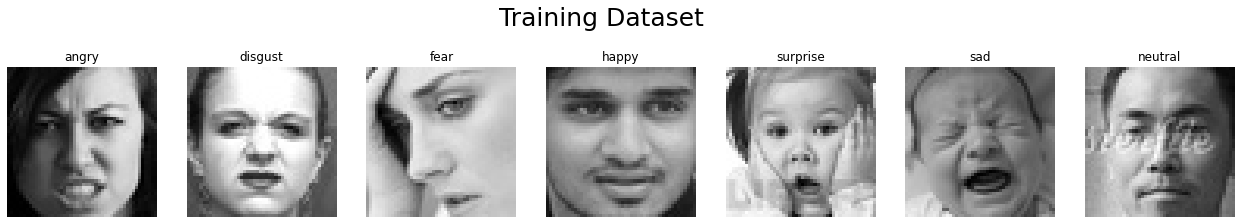

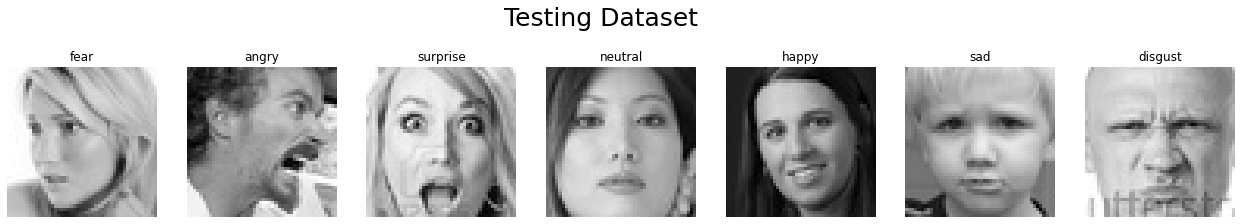

In [6]:
#showing image from dataset
def look_image(dir_,label): 
    plt.figure(figsize=(22, 22))
    plt.suptitle(label , fontsize=25, y=0.9)
    i = 1

    for exp in os.listdir(dir_):
        img = load_img((dir_ + exp + '/' + os.listdir(dir_ + exp)[1]))
        plt.subplot(5,7,i)
        plt.imshow(img)
        plt.title(exp)
        plt.ylabel("Total")
        plt.axis('off')
        i += 1  
        
train_image = look_image(trainFolder,"Training Dataset") 
test_image = look_image(testFolder,"Testing Dataset")

plt.show()


In [7]:
#Image data preprocessing
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.3,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                   )

test_data_gen = ImageDataGenerator(rescale=1./255)

training_data_set = train_data_gen.flow_from_directory(trainFolder,
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

testing_data_set = test_data_gen.flow_from_directory(testFolder,
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# training_data_set.class_indices
# testing_data_set.class_indices

#setting
numFeatures = 32
numLabels = len(training_data_set.class_indices)
batchSize = 64
epochs = 200
width = 48
height = 48
inputSize = (width,height,1)
steps_per_epoch = training_data_set.n // training_data_set.batch_size
validation_steps = testing_data_set.n // testing_data_set.batch_size

In [9]:
#setup Training Model using adaption from VGG16
def doModel(numLabels,inputSize):
    
    #creating the model
    model = Sequential()
        
    #1 layer Conv block 1
    model.add(Conv2D(numFeatures*2, kernel_size=(3, 3), activation="relu", padding = 'same',  input_shape=inputSize))
    model.add(Conv2D(numFeatures*2, kernel_size=(3, 3), activation="relu", padding='same',))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    
    #2 Conv block 2

    model.add(Conv2D(numFeatures*2*2, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(Conv2D(numFeatures*2*2, kernel_size=(3, 3), activation="relu" ,padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #3 Conv block 3

    model.add(Conv2D(numFeatures*2*2*2, kernel_size=(3, 3), activation="relu" ,padding='same'))
    model.add(Conv2D(numFeatures*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(Conv2D(numFeatures*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #4 Conv block 4

    model.add(Conv2D(numFeatures*2*2*2*2, kernel_size=(3, 3), activation="relu" ,padding='same'))
    model.add(Conv2D(numFeatures*2*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))    
    model.add(Conv2D(numFeatures*2*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #5 Conv block 5

    model.add(Conv2D(numFeatures*2*2*2*2*2, kernel_size=(3, 3), activation="relu" ,padding='same'))
    model.add(Conv2D(numFeatures*2*2*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))    
    model.add(Conv2D(numFeatures*2*2*2*2*2, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
     
    #doing Flaten and  Dense
    model.add(Flatten())
    
    #first Dence Layer
    model.add(Dense(units=4096, activation="relu"))
    
    #second Dence Layer
    model.add(Dense(units=4096, activation="relu"))
    
    #third Dence Layer    
    model.add(Dense(numLabels,activation="softmax"))
    
    #compile the model
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=["accuracy"])
    
    return model

In [10]:
#summary of model architecture
modelReady = doModel(numLabels,inputSize)
modelReady.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       2

In [11]:
#Saving summary of model architecture to pdf
plot_model(modelReady, to_file='/content/gdrive/My Drive/vgg16normal/model.pdf', 
           show_shapes=True,
           show_layer_names=True)


In [12]:
#callback funtion using saves the model after every epoch and using early stoping  for avoid overfitting(earlystop)
#and adjusts the learning rate over time using a schedule
 
log_dir = 'checkpoint/logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

checkpoint = ModelCheckpoint(filepath = '/content/gdrive/My Drive/vgg16normal/check_model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
                        
reducelearning = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=15, 
                              verbose=1, 
                              min_delta=0.0001)

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
csv_logger = CSVLogger('/content/gdrive/My Drive/vgg16normal/Logoftrain.csv')

callbacks = [checkpoint,reducelearning,earlystop,csv_logger]

In [13]:
#fitting the model
History = modelReady.fit(x=training_data_set,
                 validation_data=testing_data_set,
                 epochs=epochs,
                 verbose=1,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)




Epoch 1/200
448/448 [==============================] - 143s 312ms/step - loss: 3.7530 - accuracy: 0.2493 - val_loss: 1.8160 - val_accuracy: 0.2475

Epoch 00001: val_loss improved from inf to 1.81605, saving model to /content/gdrive/My Drive/vgg16normal/check_model.h5
Epoch 2/200
448/448 [==============================] - 54s 120ms/step - loss: 1.8100 - accuracy: 0.2512 - val_loss: 1.8142 - val_accuracy: 0.2469

Epoch 00002: val_loss improved from 1.81605 to 1.81425, saving model to /content/gdrive/My Drive/vgg16normal/check_model.h5
Epoch 3/200
448/448 [==============================] - 54s 120ms/step - loss: 1.8111 - accuracy: 0.2514 - val_loss: 1.8136 - val_accuracy: 0.2471

Epoch 00003: val_loss improved from 1.81425 to 1.81361, saving model to /content/gdrive/My Drive/vgg16normal/check_model.h5
Epoch 4/200
448/448 [==============================] - 53s 119ms/step - loss: 1.8140 - accuracy: 0.2483 - val_loss: 1.8128 - val_accuracy: 0.2471

Epoch 00004: val_loss improved from 1.81361

In [14]:
#saving model to json
saveModel = modelReady.to_json()
with open("/content/gdrive/My Drive/vgg16normal/model.json", "w") as json_file:
  json_file.write(saveModel)
modelReady.save_weights('/content/gdrive/My Drive/vgg16normal/model_weight.h5')

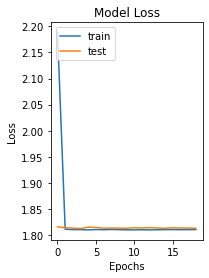

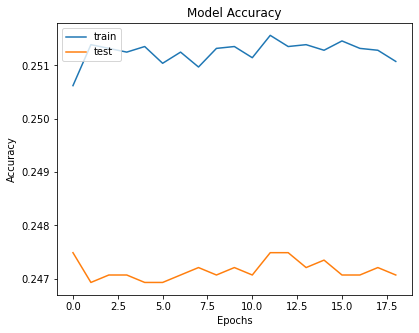

In [15]:
#Evaluation Part
#Showing the history of model

plt.subplot(1,2,1)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')


In [16]:
#evaluation part showing final data acuracy and loss
trainining_Loss, trainining_Accuration = modelReady.evaluate(training_data_set)
testing_Loss, testing_Accuration = modelReady.evaluate(testing_data_set)
print("Final Accuracy")
print("-----------------------------------")
print("Final Train accuracy = {:.2f} ".format(trainining_Accuration*100))
print("Final Test (validation) accuracy = {:.2f}\n".format(testing_Accuration*100))

print("Final Loss")
print("-----------------------------------")
print("final Train  loss = {:.2f} ".format(trainining_Loss*100))
print("final Test (Validation) loss = {:.2f}".format(testing_Loss*100))

113/113 [==============================] - 8s 74ms/step - loss: 1.8132 - accuracy: 0.2471
Final Accuracy
-----------------------------------
Final Train accuracy = 25.13 
Final Test (validation) accuracy = 24.71

Final Loss
-----------------------------------
final Train  loss = 180.99 
final Test (Validation) loss = 181.32


In [17]:
#setup Evaluation
y_pred = modelReady.predict(training_data_set)
y_pred = np.argmax(y_pred, axis=1)
y_pred_test = modelReady.predict(testing_data_set)
y_pred_test = np.argmax(y_pred_test, axis=1)
class_labels = testing_data_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
name_target = list(class_labels.values())

In [18]:
##visualization of the performance of an algorithm using confusion_matrix
confusion_matrix_train = confusion_matrix(training_data_set.classes, y_pred)
confusion_matrix_test = confusion_matrix(testing_data_set.classes, y_pred_test)
print('Training Confusion Matrix \n')
print(confusion_matrix_train , "\n")

print('Test Confusion Matrix \n')
print(confusion_matrix_test)


Training Confusion Matrix 

[[   0    0    0 3995    0    0    0]
 [   0    0    0  436    0    0    0]
 [   0    0    0 4097    0    0    0]
 [   0    0    0 7215    0    0    0]
 [   0    0    0 4965    0    0    0]
 [   0    0    0 4830    0    0    0]
 [   0    0    0 3171    0    0    0]] 

Test Confusion Matrix 

[[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]


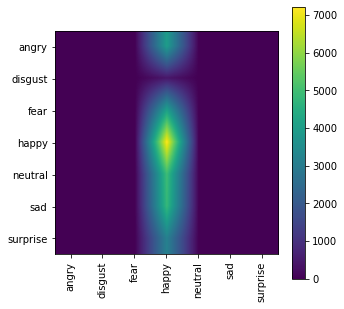

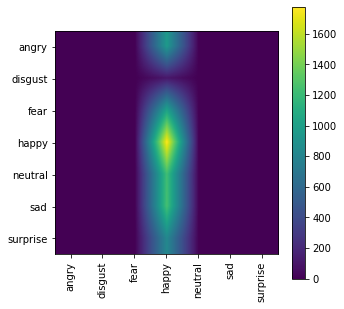

In [19]:
#showing data confusion_matrix
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_train, interpolation='bilinear')
plt.colorbar()
marking_train = np.arange(len(name_target))
_ = plt.xticks(marking_train, name_target, rotation=90)
_ = plt.yticks(marking_train, name_target)


plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_test, interpolation='bilinear')
plt.colorbar()
marking_test = np.arange(len(name_target))
_ = plt.xticks(marking_test, name_target, rotation=90)
_ = plt.yticks(marking_test, name_target)


In [20]:
#classification Report
print("------------------------------------------------------")
print('Training evaluate classifier output quality')
print("------------------------------------------------------")
print(classification_report(training_data_set.classes, y_pred, target_names=name_target),"\n")
print("------------------------------------------------------")
print('Test  evaluate classifier output quality')
print("------------------------------------------------------")
print(classification_report(testing_data_set.classes, y_pred_test, target_names=name_target))

------------------------------------------------------
Training evaluate classifier output quality
------------------------------------------------------
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      3995
     disgust       0.00      0.00      0.00       436
        fear       0.00      0.00      0.00      4097
       happy       0.25      1.00      0.40      7215
     neutral       0.00      0.00      0.00      4965
         sad       0.00      0.00      0.00      4830
    surprise       0.00      0.00      0.00      3171

    accuracy                           0.25     28709
   macro avg       0.04      0.14      0.06     28709
weighted avg       0.06      0.25      0.10     28709
 

------------------------------------------------------
Test  evaluate classifier output quality
------------------------------------------------------
              precision    recall  f1-score   support

       angry       0.00      0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
